In [6]:
import os
import pandas as pd
import numpy as np
# Changes the notebook working directory on level up.
#%cd ..

# Running main python script.
%run -i "src/main.py"

#data_set

C:\Users\aleks\Documents\Utdanning\UiS\DataScience\project\dat540-netflix_catalogue
analyse gender representation? *takes up to 10 minutes* hit: [y]n


# Movie recommendations 

The aim of this part is to create content recommondations based on a given title. 
In order to create recommondations, one needs to identify similarities between the given title and others titles in the dataset. 

The similarity between titles will be found by comparing and finding similarities in the description, genre and cast columns. 

To create recommondations, it is crucial to quantify the similarities. For this porpuse, the cosine similarity will be utlizied. The cosine similarity measures similarity between two vectors by comparing the angle between two vectors and determining if they are pointing in the same direction \[1]

To fully understand this concept before the developement of the recommendation system, a simple example is explained:

Consider two texts:

text1 = Hello Hello Goodbye

text2 = Goodbye Hello Goodbye

By identifying the words and their frequency in the two texts, the table below is acheived: 

|  | Hello | Goodbye |
| --- | --- | --- |
| textA | 2 | 1 |
| textB | 1 | 2 |

This can now be visualized as vectors: 

Text(0.5, 1.0, 'Vectorized representation of frequency of words')

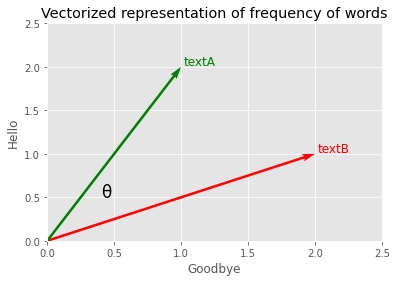

In [7]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
text1_occurences = [2,1]
text2_occurences = [1,2]
vectors = np.array([text1_occurences,text2_occurences])
origin = np.array([[0, 0],[0,0]])
plt.quiver(*origin,vectors[:,0],vectors[:,1],color=["r","g"],angles="xy",scale_units="xy",scale=1)
plt.xlim(0,2.5)
plt.ylim(0,2.5)
plt.xlabel("Goodbye")
plt.ylabel("Hello")
plt.text(0.4,0.5,"\u03B8",fontsize=17)
plt.text(1.02,2.02,"textA",fontsize=12,color="g")
plt.text(2.02,1.02,"textB",fontsize=12,color="r")
plt.title("Vectorized representation of frequency of words")


By letting $\theta$ be the angle between the two vectors, the cosine similarity  is calculated by: 
\begin{equation}
\cos \theta = \frac{A \cdot B}{ |A| \cdot |B|},
\end{equation}
where $A$ and $B$ are vectors representing the occurences of words in textA and textB, and $|A|$ and $|B|$ are the length of the vectors.
Recalling from calculus the relation between a cosine value for $\theta$ and the angle $\theta$ itself:

|  Degrees | cos $\theta$ |
|  --- | --- |
|  0 | 1 |
|  30 | 0.866 |
| 60 |  0.5 |
| 90 |  0 |

For this angle-identifying reason, the cosine similarity is used to identify similar content. The smaller the angle $\theta$ is between two vectors, the more similar the conent is. 

As mentioned above, the description, genre and cast column will be used to identify similarities. We start by extracting the dataframe with the respective columns:

In [8]:
df = data_set[["title","description","listed_in","cast"]].copy()

In order to identify cosine similarities, we need to convert the information in the columns to strings. Therefore, the columns are modified and added to a seperate column. We start by removing stopwords from the description column and cleaning it up: 

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
df

,title,description,listed_in,cast
0,Norm of the North: King Sized Adventure,Before planning an awesome wedding for his gra...,"Children & Family Movies, Comedies","Alan Marriott, Andrew Toth, Brian Dobson, Cole..."
1,Jandino: Whatever it Takes,Jandino Asporaat riffs on the challenges of ra...,Stand-Up Comedy,Jandino Asporaat
2,Transformers Prime,"With the help of three human allies, the Autob...",Kids' TV,"Peter Cullen, Sumalee Montano, Frank Welker, J..."
3,Transformers: Robots in Disguise,When a prison ship crash unleashes hundreds of...,Kids' TV,"Will Friedle, Darren Criss, Constance Zimmer, ..."
4,#realityhigh,When nerdy high schooler Dani finally attracts...,Comedies,"Nesta Cooper, Kate Walsh, John Michael Higgins..."
...,...,...,...,...
6229,Red vs. Blue,"This parody of first-person shooter games, mil...","TV Action & Adventure, TV Comedies, TV Sci-Fi ...","Burnie Burns, Jason Saldaña, Gustavo Sorola, G..."
6230,Maron,"Marc Maron stars as Marc Maron, who interviews...",TV Comedies,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh..."
6231,Little Baby Bum: Nursery Rhyme Friends,Nursery rhymes and original music for children...,Movies,Unknown cast
6232,A Young Doctor's Notebook and Other Stories,"Set during the Russian Revolution, this comic ...","British TV Shows, TV Comedies, TV Dramas","Daniel Radcliffe, Jon Hamm, Adam Godley, Chris..."


In [11]:
#Clean the description column
df["description"] = df["description"].str.lower() #converting all words to lower 
df["description"] = df["description"].str.split() #creating each description to a list
df["description"] = df["description"].apply(lambda x: pd.Series(''.join([word + ' ' for word in x if word not in stop_words]))) #series of words not in stop words
df["description"] = df["description"].apply(lambda x: x.replace(',','')) #Removing commas
df["description"] = df["description"].apply(lambda x: x.replace('.','')) #Removing dots

In [12]:
#Clean the listed in column
df["listed_in"] = df["listed_in"].str.lower()
df["listed_in"] = df["listed_in"].str.split()
df["listed_in"] = df["listed_in"].apply(lambda x: pd.Series(''.join([word + ' ' for word in x if word not in stop_words])))
df["listed_in"] = df["listed_in"].apply(lambda x: x.replace(',',''))
df["listed_in"] = df["listed_in"].apply(lambda x: x.replace('.',''))
df["listed_in"] = df["listed_in"].apply(lambda x: x.replace('&',''))

In [13]:
#Clean the cast column
df["cast"] = df["cast"].str.lower()
df["cast"] = df["cast"].apply(lambda x: x.replace(' ','')) #removing whitespace between first and last name so cosine similraity checks entire actor name, and not only first name and last name
df["cast"] = df["cast"].apply(lambda x: x.replace(',',' ')) 



In [14]:
#Combine description, listed_in and cast as new column 
df["all_info"] = df["description"] + df["listed_in"] + df["cast"]
#df.iloc[0].all_info run this line to see an example

In [15]:
df

,title,description,listed_in,cast,all_info
0,Norm of the North: King Sized Adventure,planning awesome wedding grandfather polar bea...,children family movies comedies,alanmarriott andrewtoth briandobson colehoward...,planning awesome wedding grandfather polar bea...
1,Jandino: Whatever it Takes,jandino asporaat riffs challenges raising kids...,stand-up comedy,jandinoasporaat,jandino asporaat riffs challenges raising kids...
2,Transformers Prime,help three human allies autobots protect earth...,kids' tv,petercullen sumaleemontano frankwelker jeffrey...,help three human allies autobots protect earth...
3,Transformers: Robots in Disguise,prison ship crash unleashes hundreds deceptico...,kids' tv,willfriedle darrencriss constancezimmer kharyp...,prison ship crash unleashes hundreds deceptico...
4,#realityhigh,nerdy high schooler dani finally attracts inte...,comedies,nestacooper katewalsh johnmichaelhiggins keith...,nerdy high schooler dani finally attracts inte...
...,...,...,...,...,...
6229,Red vs. Blue,parody first-person shooter games military lif...,tv action adventure tv comedies tv sci-fi fa...,burnieburns jasonsaldaña gustavosorola geoffla...,parody first-person shooter games military lif...
6230,Maron,marc maron stars marc maron interviews fellow ...,tv comedies,marcmaron juddhirsch joshbrener norazehetner a...,marc maron stars marc maron interviews fellow ...
6231,Little Baby Bum: Nursery Rhyme Friends,nursery rhymes original music children accompa...,movies,unknowncast,nursery rhymes original music children accompa...
6232,A Young Doctor's Notebook and Other Stories,set russian revolution comic miniseries based ...,british tv shows tv comedies tv dramas,danielradcliffe jonhamm adamgodley christopher...,set russian revolution comic miniseries based ...


Now that we for each title have a single column containing information about the description, the genres and the cast, we can count instances of different words and create a matrix containing instances count of unique words. This can be acheived by using sklearn.feature_extraction.text.CountVectorizer, which is described to "convert a collection of text documents to a matrix of token counts \[2]. 

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer() #Initialize a CountVectorizer object
count_matrix = cv.fit_transform(df["all_info"]) # Identify and count instances in the "all_info" column. 
# print(count_matrix.toarray()) print this line to get a feeling of what the count_matrix looks like

Once the count_matrix is acheived, the next step is to find the cosine similarity. For this purpose, sklearn.metrics.pairwise.cosine_similarity is used \[3].

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(count_matrix) #Now the cosine similarities have been quantified
#print(cos_sim) print this line to get a feeling of what cosine sims looks like

#Defining two helper functions
def get_title_from_idx(df,idx):
    """
    Returns the title of a entry from a given index
    """
    return df[df.index == idx].title.values[0]
#df[df.index == index]["title"].values[0]

def get_idx_from_title(df,title):
    """
    Returns the index of a movie from a given title
    """
    return df[df["title"]==title].index.values.astype(int)[0]

In [18]:
title_user_likes = "Transformers Prime" #Test code for transformers prime
title_idx = get_idx_from_title(df,title_user_likes) #identify the index of the title that the user likes

With the index of the movie, we can find the list of the cosine similarities for the specific title. This is done by:

In [19]:
specific_cos_sim = cos_sim[title_idx]

We need to keep track of the indexes elements in the specific_cos_sim scores. By enumerating, the array of cosine similarity scores are converted into tuples containing the index and the scores. Finally, by converting these tuples into a list, we get a list of tuples containing the index and the scores:

In [20]:
similar_content = list(enumerate(specific_cos_sim))

Now we wish to sort the list of tuples based on similarity scores. 

This is acheived by using the built-in sorted() function in python. The sorted() function buils a new list. In the official documentation for the sorted()-function, it says that the key should specify a function of one argument that is used to extract a comparison key for each element in the iterable \[4]. We wish to sort on second value for each tuple (wich is the cosine similirity score). I therefore define a function to acheive this:

In [35]:
def key_func(val):
    return val[1]

sorted_similar = sorted(similar_content,key=key_func,reverse=True) #using reverse because we wish to sort by descending order
#note, could also have used key = lambda x: x[1]
sorted_similar_suggestions = sorted_similar[1:] #Skip the first because this will suggest itself


#Print top 5 similar content:
print("Most similar titles to "+ title_user_likes + " are:")
for e in sorted_similar_suggestions[0:5]:
    print(get_title_from_idx(df,e[0])) #As above, we have a list of tuples, where index 0 is key and inde 1 is cosine sim score. Therefore give index (e[0]) to function.
        

Most similar titles to Transformers Prime are:
Transformers: Robots in Disguise
You vs. Wild
All Hail King Julien: Exiled
We Bare Bears
Mutant Busters


As seen from the above list, when entering Transformers Prime as liked content, the code returns content similar to this. This is specially noticeable as the top similar content is another Transformers movie, and we can therefore conclude that this recommondation system works fine. 

In [426]:
#Defining the last part as a function and test a couple of times:

def title_recommender(df):
    user_likes_title = input("What title do you like? ")
    user_likes_idx = get_idx_from_title(df,user_likes_title)
    specific_cos_sim = cos_sim[user_likes_idx]
    similar_content = list(enumerate(specific_cos_sim))
    sorted_similar = sorted(similar_content,key=key_func,reverse=True)[1:]
    print("Most similar titles to "+ user_likes_title + " are:")
    for e in sorted_similar[0:5]:
        print(get_title_from_idx(df,e[0])) 
        

In [427]:
title_recommender(df)

What title do you like? Breaking Bad
Most similar titles to Breaking Bad are:
Have You Ever Fallen in Love, Miss Jiang?
Age of Rebellion
Unit 42
Better Call Saul
Pyaar Tune Kya Kiya


We see that one of the suggestions for Breaking Bad is Better Call Saul. This verify the code that the implementation works well, as the two TV shows are related. 

#### Sources

\[1] Kamber, M., Han, J. & Pei, J. Data Mining (Third Edition), p.39-81 [online]. Accessed 03/12/20. Available at < https://www.sciencedirect.com/science/article/pii/B9780123814791000022 >

\[2] sklearn.feature_extraction.text.CountVectorizer [online]. Accessed 03/12/20. Available at < https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html >

\[3] sklearn.metrics.pairwise.cosine_similarity [online]. Accessed 04/12/20. Available at < https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html >

\[4] Python Built-In Functions [online]. Accessed 05/12/20. Available at < https://docs.python.org/3/library/functions.html#sorted >
